In [1]:
import torch
import torch.nn as nn

from fairseq.models.bart import BARTModel

In [2]:
bart = BARTModel.from_pretrained('/home/ml/cadencao/Downloads/BART_models/bart.large',
                                 checkpoint_file='model.pt',
                                 data_name_or_path='/home/ml/cadencao/Downloads/BART_models/bart.large')

In [3]:
bart.cuda()
bart.eval()
print('- Activate evaluation mode')

- Activate evaluation mode


In [4]:
encode_func = bart.encode
decode_func = bart.decode

In [5]:
bart_encoder = bart.model.encoder
bart_decoder = bart.model.decoder

#### Read XSum

In [6]:
from utils import read_lines

In [7]:
document_path = '/home/ml/cadencao/XSum/fairseq_files/train.source'
target_path = '/home/ml/cadencao/XSum/fairseq_files/train.target'
xsum_source = read_lines(document_path)
xsum_target = read_lines(target_path)
print(len(xsum_source))
assert len(xsum_source) == len(xsum_target)

203575


#### Read Loss Data

In [8]:
from os import listdir
from os.path import isfile, join

In [9]:
ID = 4
folder = 'cedar_losses/'

files = [f for f in listdir(folder) if isfile(join(folder, f)) and f[:len(str(ID))] == str(ID) and f[len(str(ID))] == '.']
files.sort()

In [10]:
files

['4.20200705_005134.obj',
 '4.20200705_012332.obj',
 '4.20200705_030657.obj',
 '4.20200705_052702.obj',
 '4.20200705_073900.obj',
 '4.20200705_085253.obj',
 '4.20200705_110519.obj',
 '4.20200705_124253.obj',
 '4.20200705_135741.obj',
 '4.20200705_162811.obj',
 '4.20200705_164219.obj',
 '4.20200705_193343.obj',
 '4.20200705_212223.obj',
 '4.20200705_215817.obj']

#### Extract Losses

In [11]:
import numpy as np

In [12]:
target = None
losses = []

for f in files:
    s = torch.load(join(folder, f), map_location='cpu')
    if target is None:
        target = s['sample']['target'][0]
    else:
        assert torch.all(target.eq(s['sample']['target'][0])).item()
    token_loss = s['token_loss'].view(s['sample']['target'].shape)[0]
    assert token_loss.shape == target.shape
    losses.append(token_loss.numpy())

losses = np.array(losses).T

In [13]:
print(losses.shape)
print(target)

(30, 14)
tensor([19877,   571,  4031,    18,  1813,   263,   272,  1397,    90,   362,
           41,  3444,  5540,  1124,    15,     5,  1273,  1289,     9,     5,
        15143,   254,  4031,  4279,   211,  1180,  3792,   833,     4,     2])


#### Analysis

In [14]:
from utils import tokenize, decode_sequence, get_probability

In [15]:
print(decode_func(target))

Belgium's Thomas de Gendt took an impressive solo victory on the opening stage of the Criterium du Dauphine.


In [16]:
for i, t in enumerate(target[:-1]):
    # print('{} ({})'.format(decode_func(t.unsqueeze(dim=0)), i), end=' ')
    print('- {} {}'.format(i, decode_func(t.unsqueeze(dim=0))))

- 0 Bel
- 1 g
- 2 ium
- 3 's
- 4  Thomas
- 5  de
- 6  G
- 7 end
- 8 t
- 9  took
- 10  an
- 11  impressive
- 12  solo
- 13  victory
- 14  on
- 15  the
- 16  opening
- 17  stage
- 18  of
- 19  the
- 20  Crit
- 21 er
- 22 ium
- 23  du
- 24  D
- 25 au
- 26 ph
- 27 ine
- 28 .


In [17]:
%matplotlib inline

import matplotlib.pyplot as plt

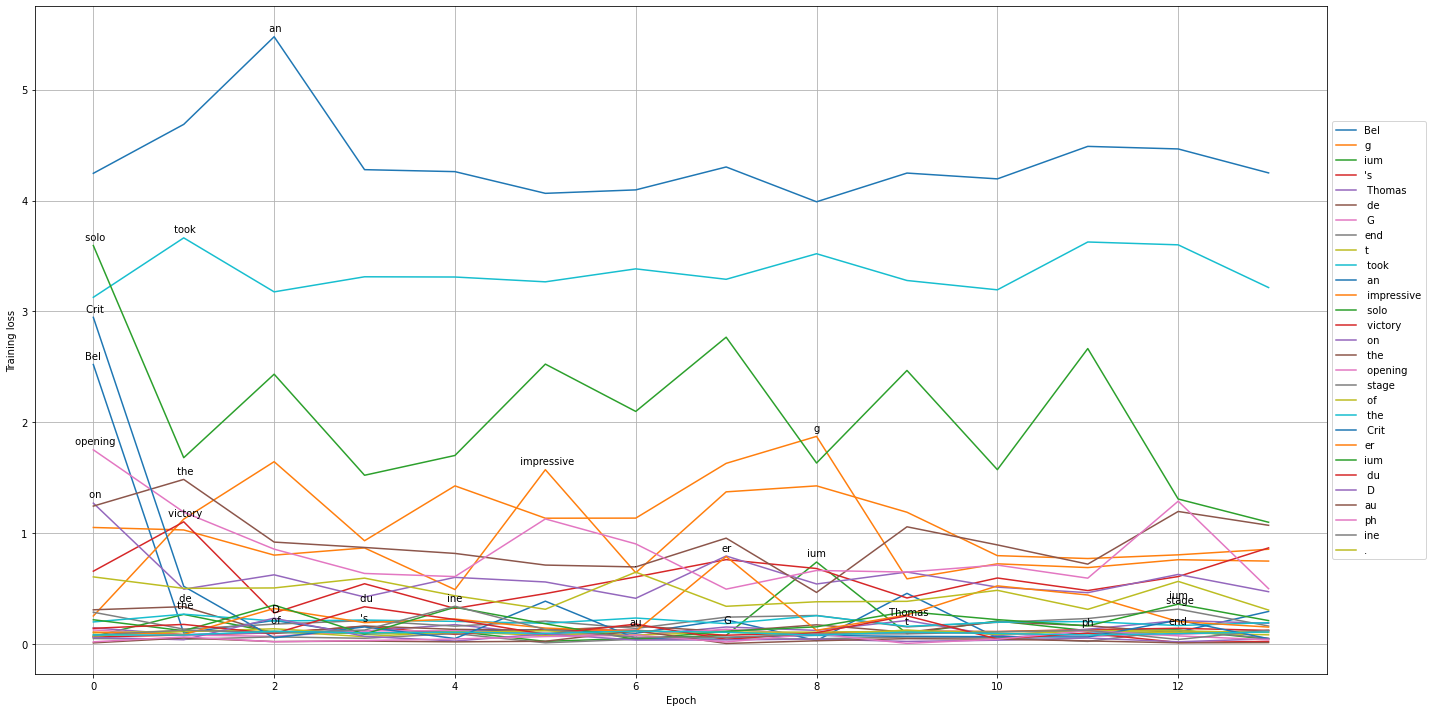

In [37]:
display_index = [0, 1, 2, 3, 18, 20, 21, 24, 25, 26]
display_index = [0, 1, 2, 20, 21, 22, 23, 24, 25, 26, 27]
display_index = None

x = np.arange(0, losses.shape[1], 1)

fig, axs = plt.subplots(figsize=(20.0, 10.0))

count = 0
for i, t in enumerate(target):
    if t.item() == 1: break
    word = decode_func(t.unsqueeze(dim=0))
    if display_index is None or i in display_index:
        axs.plot(x, losses[i], label=word)
        
        text_index = np.argmax(losses[i])
        axs.text(text_index, losses[i][text_index] + 0.05, word,
                 horizontalalignment='center')
        count += 1

axs.set_xlabel('Epoch')
axs.set_ylabel('Training loss')
axs.grid(True)

# plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()
plt.savefig('foo.png')
plt.show()

In [19]:
xsum_target[ID]

"Belgium's Thomas de Gendt took an impressive solo victory on the opening stage of the Criterium du Dauphine."

In [20]:
def tokenize_with_mask(input_sentence):
    bpe_code = bart.bpe.encode(input_sentence)  # <mask>: 1279 27932 29
    input_ids = bart.task.source_dictionary.encode_line('<s> ' + bpe_code.replace('1279 27932 29', '<mask>'), 
                                                        append_eos=True).long()
    input_ids = input_ids.unsqueeze(0).cuda()
    src_lengths = torch.sum(input_ids != 1, dim=1)
    return input_ids, src_lengths

In [21]:
word_pieces = [decode_func(t.unsqueeze(dim=0)) for t in target[:-1]]
print(word_pieces)

['Bel', 'g', 'ium', "'s", ' Thomas', ' de', ' G', 'end', 't', ' took', ' an', ' impressive', ' solo', ' victory', ' on', ' the', ' opening', ' stage', ' of', ' the', ' Crit', 'er', 'ium', ' du', ' D', 'au', 'ph', 'ine', '.']


In [22]:
import math

with torch.no_grad():
    for wp in word_pieces:
        masked_target = xsum_target[ID].replace(wp, '<mask>', 1)

        masked_input, masked_lengths = tokenize_with_mask(masked_target)
        masked_outputs = decode_sequence(decode_func,
                                         bart_decoder,
                                         bart_encoder(masked_input, src_lengths=masked_lengths),
                                         tgt_tokens=target.cuda(),
                                         verbose=False)
        masked_output_ids, masked_tokens, masked_token_probs, token_logits = masked_outputs
        assert decode_func(masked_output_ids[0]) == xsum_target[ID]
        
        loss = -math.log(masked_token_probs[masked_tokens.index(wp)])
        print('- {}: {}'.format(wp, loss))

- Bel: 11.793557272495006
- g: 15.025229145286614
- ium: 14.71636644845741
- 's: 12.148780140738173
-  Thomas: 14.1100810560843
-  de: 17.170454906922384
-  G: 18.51802403721062
- end: 9.530421874548592
- t: 18.615048046371783
-  took: 13.06335487786549
-  an: 10.701462371281234
-  impressive: 15.152397211777943
-  solo: 17.914118094856324
-  victory: 8.09631376474622
-  on: 10.309852362498104
-  the: 7.017971753817988
-  opening: 13.403612452044523
-  stage: 8.940588142942289
-  of: 7.803158588614767
-  the: 7.017971753817988
-  Crit: 19.41440784697321
- er: 7.523125696968888
- ium: 14.71636644845741
-  du: 12.97995889077518
-  D: 15.261771293059354
- au: 7.733541679762411
- ph: 11.863146766920856
- ine: 8.561187492311882
- .: 10.382484489862849


In [23]:
decode_func(torch.tensor([41552, 43776, 15698]))

'<mask>'

In [24]:
target

tensor([19877,   571,  4031,    18,  1813,   263,   272,  1397,    90,   362,
           41,  3444,  5540,  1124,    15,     5,  1273,  1289,     9,     5,
        15143,   254,  4031,  4279,   211,  1180,  3792,   833,     4,     2])

In [25]:
# tokenize
src_tokens, src_lengths = tokenize(xsum_source[ID], encode_func)

In [26]:
target_ = torch.cat([torch.tensor([0]), target], dim=0)

In [27]:
torch.cat([target_[:1], torch.tensor([41552, 43776, 15698])], dim=0)

tensor([    0, 41552, 43776, 15698])

In [28]:
encoder_out = bart_encoder(torch.cat([target_[:1], torch.tensor([41552, 43776, 15698])], dim=0).unsqueeze(0).cuda(),
                           src_lengths=torch.tensor([4]).cuda())

In [29]:
torch.cat([target_[:1], torch.tensor([41552, 43776, 15698])], dim=0).cuda()

tensor([    0, 41552, 43776, 15698], device='cuda:0')

In [30]:
decoder_outputs = bart_decoder(torch.tensor([[2, 0]], dtype=torch.long).cuda(), encoder_out, features_only=False)

In [31]:
logits = decoder_outputs[0][:, -1, :]

In [32]:
logits.shape

torch.Size([1, 50265])

In [33]:
target

tensor([19877,   571,  4031,    18,  1813,   263,   272,  1397,    90,   362,
           41,  3444,  5540,  1124,    15,     5,  1273,  1289,     9,     5,
        15143,   254,  4031,  4279,   211,  1180,  3792,   833,     4,     2])

In [34]:
softmax = nn.Softmax(dim=1)

In [35]:
with torch.no_grad():
    for i, t in enumerate(target[:-1]):
        start_token, end_token = torch.tensor([0]), torch.tensor([2])
        mask_token = torch.tensor([41552, 43776, 15698])

        src_tokens = torch.cat([start_token, target[: i], mask_token, end_token], dim=0).unsqueeze(dim=0).cuda()
        src_lengths = torch.tensor([src_tokens.shape[1]]).cuda()
        prev_output_tokens = torch.cat([torch.tensor([2, 0]), target[: i]], dim=0).unsqueeze(dim=0).cuda()

        encoder_out = bart_encoder(src_tokens, src_lengths=src_lengths)
        decoder_outputs = bart_decoder(prev_output_tokens, encoder_out, features_only=False)
        logits = decoder_outputs[0][:, -1, :]  # [batch_size, vocab]
        
        probs = softmax(logits)
        token, prob = decode_func(t.unsqueeze(dim=0)), probs.squeeze()[t.item()].item()
        print('- {}: {}'.format(token, -math.log(prob)))

- Bel: 23.115477111458357
- g: 18.94463146485373
- ium: 19.291976820924308
- 's: 20.55934029036082
-  Thomas: 25.98633577176134
-  de: 19.916166276315153
-  G: 16.443770155647965
- end: 13.96362390600685
- t: 18.112484561668985
-  took: 19.1436915976925
-  an: 15.866119922306542
-  impressive: 18.018485600639266
-  solo: 18.438712318300162
-  victory: 8.958032284036712
-  on: 12.665017177053931
-  the: 8.389347647827213
-  opening: 10.63421384732528
-  stage: 10.101739503388266
-  of: 10.465008533594158
-  the: 8.295116758952
-  Crit: 14.771625682903887
- er: 9.843804612822263
- ium: 8.98566568748153
-  du: 14.262050296522496
-  D: 8.928731417017605
- au: 3.5046381966525937
- ph: 16.933931402442628
- ine: 12.579135288066913
- .: 10.382484489862849


In [36]:
torch.tensor([    0, 41552, 43776, 15698,     2]).shape[0]

5